In [1]:
import openslide
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.dpi'] = 100 # for high resolution figure

In [2]:
import matplotlib as mpl
import openslide
import pandas as pd
import shapely.ops
import cv2
from skimage import morphology
import cv2 as cv
from shapely.geometry import Polygon, MultiPolygon, box
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import random
import numpy as np
from shapely.strtree import STRtree
import geojson
from pathlib import Path

In [3]:
# from ovarian_utils import simple_get_mask, is_artifact, translate_coords, get_tissue_regions, get_grid, MultiPolygon
from ovarian_utils import is_artifact, translate_coords, get_tissue_regions, get_grid, MultiPolygon

### for 7-24 slides

import cv2 as cv
from skimage.morphology import disk
from skimage import morphology
import numpy as np

def simple_get_mask(img):
    gray = cv.cvtColor(np.asarray(img), cv.COLOR_RGB2GRAY)    
    _, mask = cv.threshold(gray, 0, 200, cv.THRESH_OTSU) # threshold using the OTSU method
    # mask = cv.adaptiveThreshold(blur,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,11,2)
    mask = morphology.remove_small_objects(mask == 0, min_size=100, connectivity=2)
    mask = morphology.remove_small_holes(mask, area_threshold=100)
    mask = morphology.binary_dilation(mask, morphology.disk(1))
    return mask

In [9]:
############## tiles from geojson Margin areas ###########
def read_qupath_json(json_path):
    with open(json_path) as f:
        slide_objects = geojson.load(f)
        print(len(slide_objects))

        slide_object_coordinates = [slide_objects[i]['geometry']['coordinates'][0] for i in range(len(slide_objects))]
        return slide_object_coordinates
    
def read_geojson(jsonpath):
    with open(jsonpath) as f:
        allobjects = geojson.load(f)

    #allshapes = [shape(obj["geometry"]) for obj in allobjects]
    allfeatures = allobjects['features']
    allshapes = [obj["geometry"]['coordinates'] for obj in allfeatures]
    alllabels = [obj['properties'] for obj in allfeatures]
    roilabels = list()
    for roi_num in range(0, len(alllabels)):
        roi_label = alllabels[roi_num]['classification']['name']
        roilabels.append(roi_label)
    
    return allshapes, roilabels

def read_geojson_nolabel(jsonpath):
    with open(jsonpath) as f:
        allobjects = geojson.load(f)

    #allshapes = [shape(obj["geometry"]) for obj in allobjects]
    allfeatures = allobjects['features']
    allshapes = [obj["geometry"]['coordinates'] for obj in allfeatures]
    alllabels = [obj['properties'] for obj in allfeatures]
    
    return allshapes

In [5]:
requested_magn = 20
downsample = int(40/requested_magn) # Use 4 for 10x, 2 for 20x, 1 for 40x
tile_size = int(500*downsample) # Use 2000 for 10x, 1000 for 20x, 500 for 40x
overlap = int(50*downsample)
print('downsample',downsample, 'tile_size', tile_size, 'overlap', overlap)

downsample 2 tile_size 1000 overlap 100


In [ ]:
# import pandas as pd

# batch = '15_DGX_pipeline_batch_Ramya1.csv'

# df = pd.read_csv(batch)

# imgs = []
# for i in range(len(df)):
#     path = Path(str(df['rand_paths'][i]))
#     imgs.append(str(path.stem))
    
# print(len(imgs))
# print(imgs)

In [ ]:
# slide_dir_path = Path('/raid/aarlova/NIH/NIH')
# imgs = []
# for f in slide_dir_path.iterdir():
#     if f.suffix == '.ndpi':
#         imgs.append(str(f.stem))
        
# # print(imgs)
# print(len(imgs))

# batch = 'NIH'

In [6]:
jsons_dir_path = Path('margin_jsons_for_NIH')
jsons = []
for f in jsons_dir_path.iterdir():
    if f.suffix == '.geojson':
        jsons.append(str(f.name)[:-8])
        
print(len(jsons))
print(jsons)

jsons = [j for j in jsons if jsons if '10921' not in j and '3561' not in j and '1205' not in j]
print(len(jsons))

45
['SB-22-5319-A1-001-2022-10-04 15.37.46', 'SB-21-10921-A-1-SL5', 'SB-22-4887-A1-CKIT-2022-10-04 15.24.47', 'SB-22-6626-B1-AE1-AE3-2022-10-04 15.02.56', 'SB-22-6626-A1-PR-2022-10-04 14.45.52', 'SB-22-5319-A1-003-2022-10-04 15.35.43', 'SB-22-1759-A-1-SL5', 'SI-21-9630-A-1-SL1-2022-07-11-15.00.36', 'SB-22-6626-B1-ER-2022-10-04 15.04.39', 'SB-22-6626-A1-005-2022-10-04 14.42.36', 'SB-22-1759-B-1-SL1', 'SB-22-4887-A1-003-2022-10-04 15.19.47', 'SI-22-1205-A-1-SL1', 'SB-22-1548-A-1-SL2-2022-07-11-16.18.47', 'SB-22-3561-A-1-SL1-2022-07-11-17.33.19', 'SB-22-6626-B1-003-2022-10-04 14.50.45', 'SB-22-3561-A-1-SL5-2022-07-11-17.40.46', 'SB-22-6626-A1-003-2022-10-04 14.40.23', 'SB-22-1759-B-1-SL5', 'SB-22-5319-A1-005-2022-10-04 15.33.12', 'SB-22-6626-A1-Inhibin-2022-10-04 14.44.34', 'SB-22-6626-A1-ER-2022-10-04 14.46.45', 'SB-22-6626-B1-005-2022-10-04 14.53.51', 'SB-22-6626-B1-Inhibin-2022-10-04 15.01.29', 'SB-22-1759-A-1-SL3', 'SI-22-1205-A-1-SL5', 'SB-22-1548-A-1-SL5', 'SB-22-1548-A-1-SL1', 'SI-

In [7]:
slide_dir = '/raid/aarlova/NIH/NIH/'
save_dir = '/raid/aarlova/NIH/NIH/tiles_20x'
save_info_dir = '/media/14TB/aarlova_ovarian/slide_tiling_info_NIH/'
slide_list = jsons

# <font size="5">Tiles from Masked Thumbnails</font>

In [ ]:
######################## get tiles from masked thumbnails #########################

import traceback

batch = 'finishing_tiling'

failed = []
for i in range(len(slide_list)):

    slide_fname = Path(slide_dir + '/' + slide_list[i] + '.ndpi')
    print('Working on Slide', i, slide_fname)

    slide = openslide.OpenSlide(str(slide_fname))
    print('opened slide!')
    levels = int(slide.level_count)
    thumb_dim = slide.level_dimensions[levels - 3]  # highest level corresponds to smallest available dimension
    thumbnail_downsample_factor = int(slide.level_downsamples[levels - 3])  # corresponding downsample factor of the thumbnail to be produced

    wsi_thumb = slide.get_thumbnail(thumb_dim)
    plt.imshow(wsi_thumb)
    plt.savefig(save_info_dir+str(slide_fname.stem)+'_thumb.jpg')

    plt.axis('off')
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()

    wsi_thumbnail_mask = simple_get_mask(wsi_thumb)

    tissue_regions = get_tissue_regions(wsi_thumbnail_mask, thumbnail_downsample_factor, save=True, save_name=save_info_dir+str(slide_fname.stem)+'_thumb_mask.jpg')

    #######################################################################
    # generate a grid of tiles of specific size and overlap within bounds of the Ovary
    print('Set tile size to', tile_size, ', and overlap to', overlap)
    slide_grid = get_grid(tissue_regions, tile_size, overlap, plot=False) # slide_grid is a nested list of Polygons. Len(slide_grid) is how many sections of tissue are on slide.
    print('Done tiling the slide!')

    #######################################################################
    print('Number of sections in slide:', len(slide_grid))

#     for section in range(len(slide_grid)):
#         if len(slide_grid[section]) == 0:
#             pass
#         else:
            
#             print('Number of tiles in current section:', len(slide_grid[section]))


#             for tile in range(len(slide_grid[section])):
#                 current_tile = slide_grid[section][tile]
#                 current_tile_top_left_coord = [int(current_tile.bounds[0]), int(current_tile.bounds[1])]  # this should be minx, miny if polygons were created with ccw=False
#                 tile_name = save_dir + str(slide_fname.stem) + '/' + str(slide_fname.stem) + ' [x=' + str(current_tile_top_left_coord[0]) + ',y=' + str(current_tile_top_left_coord[1]) + ',w='+str(tile_size) + ',h=' + str(tile_size) + '].jpg'
#                 tile_img = slide.read_region((current_tile_top_left_coord[0], current_tile_top_left_coord[1]),0,(tile_size,tile_size)).convert('RGB')
#                 resized_tile = tile_img.resize((500,500))


#                 Path(tile_name).parent.mkdir(parents=True, exist_ok=True) # creates a parent directory for saving tiles from one slide

#                 resized_tile.save(tile_name)

#                 tile_img.close()
#                 resized_tile.close()


#             print('done processing tiles in section', section)

#     print('done with all sections')


    slide.close()
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

    # except Exception:
    #     traceback.print_exc()
    #     failed.append(slide_list[i])

    # if len(failed) > 0:
    #     file1 = open(batch+"_failed.txt","w")
    #     for f in failed:
    #         file1.write(f + '\n')
    #     file1.close()



# <font size="5">Tiles from geojson Margin areas</font>

~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-5319-A1-001-2022-10-04 15.37.46.ndpi


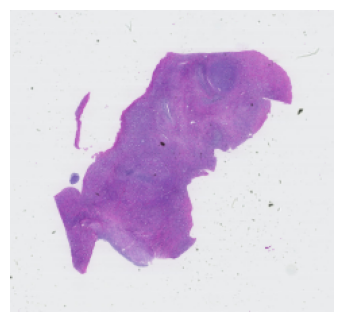

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 3
done saving tiles in section 0
done saving tiles in section 1
done saving tiles in section 2
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-4887-A1-CKIT-2022-10-04 15.24.47.ndpi


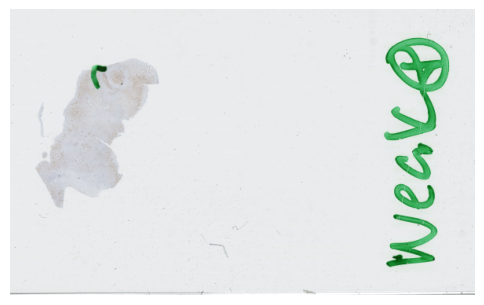

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 1
done saving tiles in section 0
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-6626-B1-AE1-AE3-2022-10-04 15.02.56.ndpi


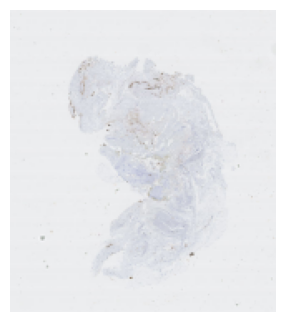

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 1
done saving tiles in section 0
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-6626-A1-PR-2022-10-04 14.45.52.ndpi


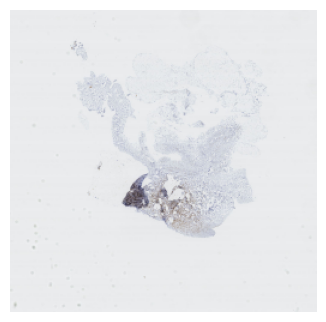

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 1
done saving tiles in section 0
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-5319-A1-003-2022-10-04 15.35.43.ndpi


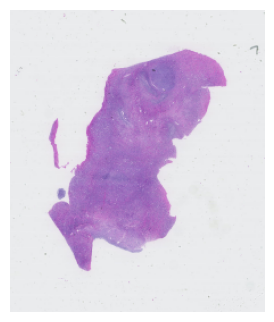

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 4
done saving tiles in section 0
done saving tiles in section 1
done saving tiles in section 2
done saving tiles in section 3
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-1759-A-1-SL5.ndpi


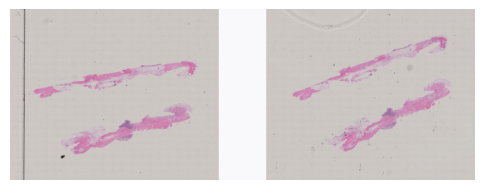

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 4
done saving tiles in section 0
done saving tiles in section 1
done saving tiles in section 2
done saving tiles in section 3
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SI-21-9630-A-1-SL1-2022-07-11-15.00.36.ndpi


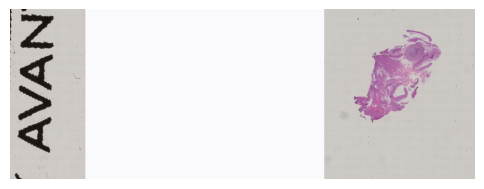

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 1
done saving tiles in section 0
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-6626-B1-ER-2022-10-04 15.04.39.ndpi


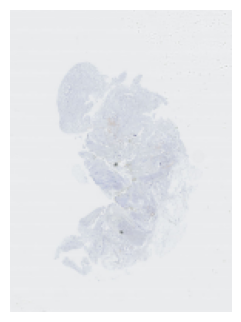

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 1
done saving tiles in section 0
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-6626-A1-005-2022-10-04 14.42.36.ndpi


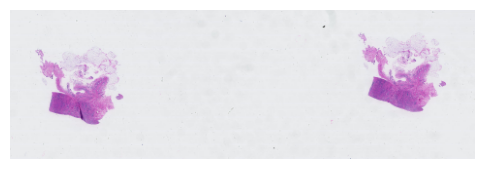

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 4
done saving tiles in section 0
done saving tiles in section 1
done saving tiles in section 2
done saving tiles in section 3
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-1759-B-1-SL1.ndpi


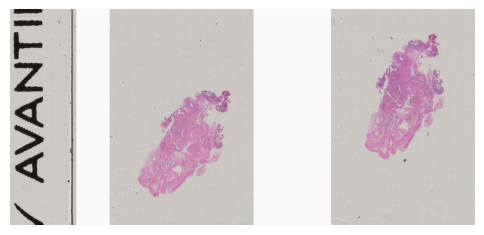

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 2
done saving tiles in section 0
done saving tiles in section 1
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-4887-A1-003-2022-10-04 15.19.47.ndpi


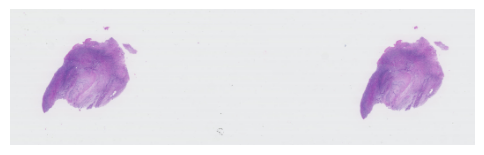

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 4
done saving tiles in section 0
done saving tiles in section 1
done saving tiles in section 2
done saving tiles in section 3
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-1548-A-1-SL2-2022-07-11-16.18.47.ndpi


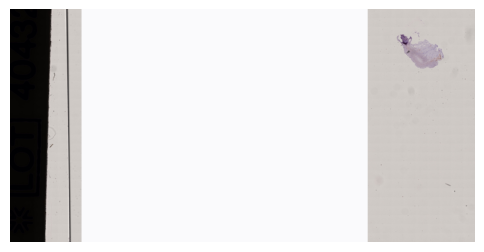

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 1
done saving tiles in section 0
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-6626-B1-003-2022-10-04 14.50.45.ndpi


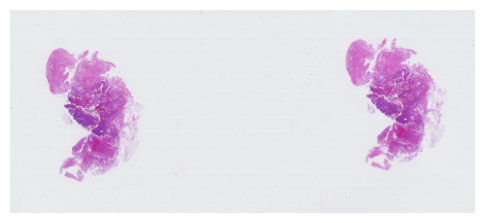

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 2
done saving tiles in section 0
done saving tiles in section 1
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-6626-A1-003-2022-10-04 14.40.23.ndpi


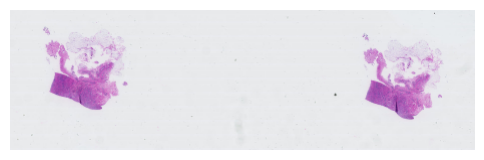

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 2
done saving tiles in section 0
done saving tiles in section 1
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-1759-B-1-SL5.ndpi


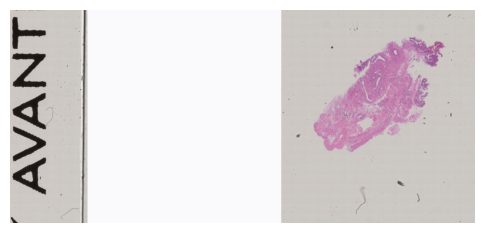

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 1
done saving tiles in section 0
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-5319-A1-005-2022-10-04 15.33.12.ndpi


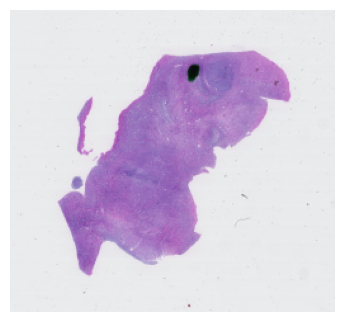

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 2
done saving tiles in section 0
done saving tiles in section 1
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-6626-A1-Inhibin-2022-10-04 14.44.34.ndpi


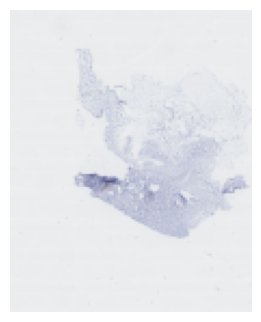

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 1
done saving tiles in section 0
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-6626-A1-ER-2022-10-04 14.46.45.ndpi


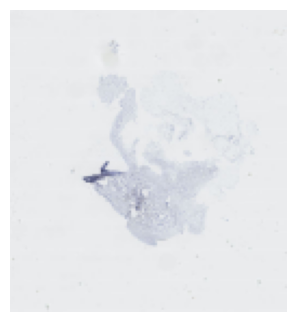

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 1
done saving tiles in section 0
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-6626-B1-005-2022-10-04 14.53.51.ndpi


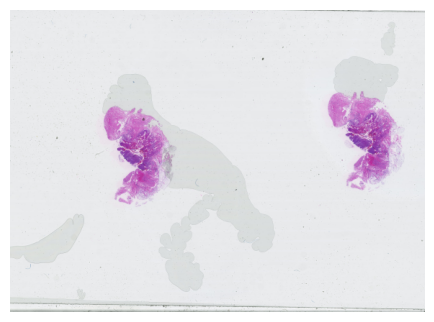

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 2
done saving tiles in section 0
done saving tiles in section 1
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-6626-B1-Inhibin-2022-10-04 15.01.29.ndpi


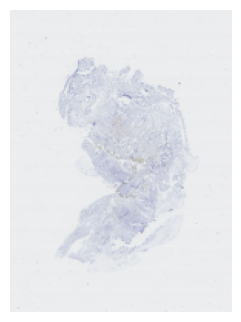

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 1
done saving tiles in section 0
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-1759-A-1-SL3.ndpi


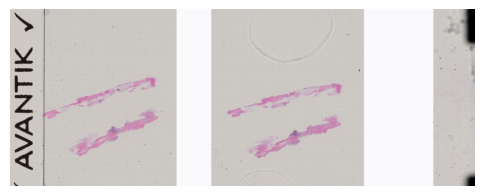

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 4
done saving tiles in section 0
done saving tiles in section 1
done saving tiles in section 2
done saving tiles in section 3
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-1548-A-1-SL5.ndpi


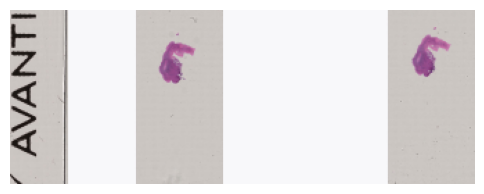

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 2
done saving tiles in section 0
done saving tiles in section 1
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-1548-A-1-SL1.ndpi


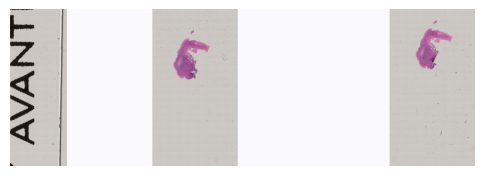

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 2
done saving tiles in section 0
done saving tiles in section 1
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SI-22-4383-A-1-SL5-2022-07-11-18.06.34.ndpi


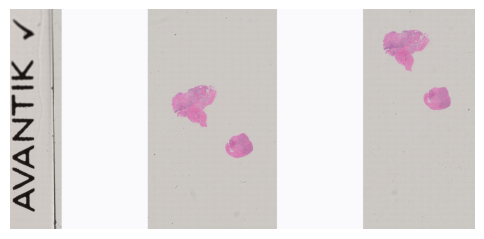

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 4
done saving tiles in section 0
done saving tiles in section 1
done saving tiles in section 2
done saving tiles in section 3
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-6626-B1-SMA-2022-10-04 14.59.44.ndpi


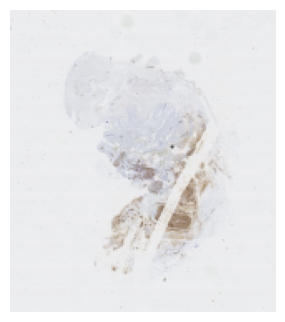

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 3
done saving tiles in section 0
done saving tiles in section 1
done saving tiles in section 2
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-6626-A1-001-2022-10-04 14.38.36.ndpi


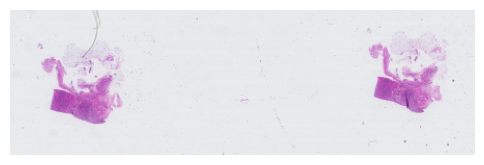

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 2
done saving tiles in section 0
done saving tiles in section 1
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-1759-B-1-SL3.ndpi


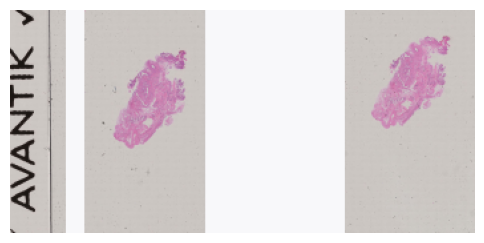

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 2
done saving tiles in section 0
done saving tiles in section 1
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-1548-A-1-SL3.ndpi


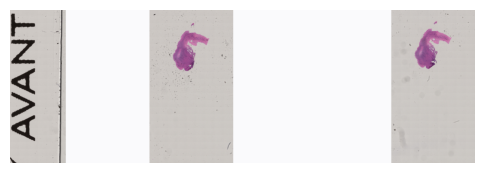

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 2
done saving tiles in section 0
done saving tiles in section 1
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-6626-B1-001-2022-10-04 14.48.02.ndpi


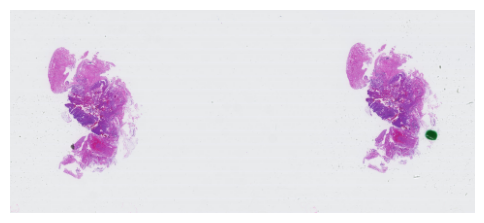

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 4
done saving tiles in section 0
done saving tiles in section 1
done saving tiles in section 2
done saving tiles in section 3
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-4887-A1-005-2022-10-04 15.17.15.ndpi


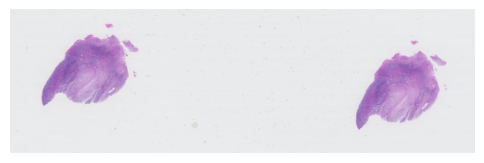

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 2
done saving tiles in section 0
done saving tiles in section 1
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-6626-B1-CK7-2022-10-04 15.07.37.ndpi


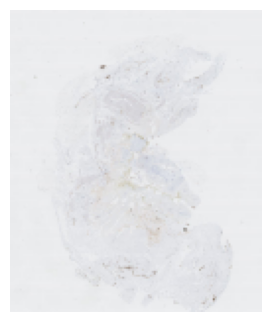

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 1
done saving tiles in section 0
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SI-22-4383-A-1-SL1-2022-07-11-17.48.02.ndpi


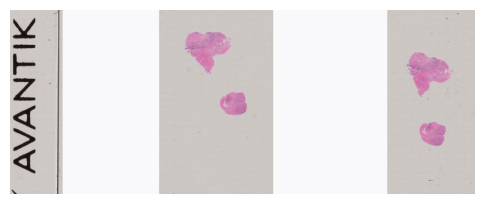

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 4
done saving tiles in section 0
done saving tiles in section 1
done saving tiles in section 2
done saving tiles in section 3
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-1759-A-1-SL1.ndpi


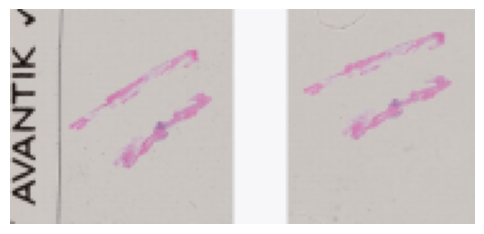

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 4
done saving tiles in section 0
done saving tiles in section 1
done saving tiles in section 2
done saving tiles in section 3
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-6626-B1-PR-2022-10-04 15.05.56.ndpi


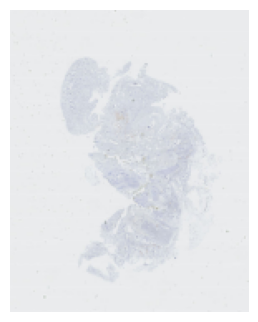

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 1
done saving tiles in section 0
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-4887-A1-Oct4-2022-10-04 15.29.56.ndpi


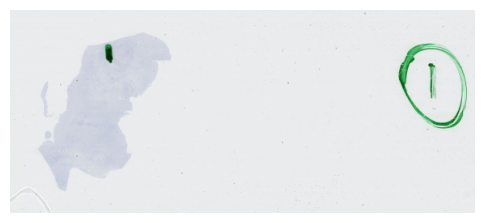

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 3
done saving tiles in section 0
done saving tiles in section 1
done saving tiles in section 2
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SI-22-4383-A-1-SL3-2022-07-11-17.57.16.ndpi


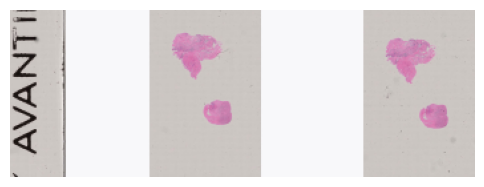

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 4
done saving tiles in section 0
done saving tiles in section 1
done saving tiles in section 2
done saving tiles in section 3
done with all sections
~~~~~~~~~~~~~~~~~~~~~~
/raid/aarlova/NIH/NIH/SB-22-4887-A1-001-2022-10-04 15.22.26.ndpi


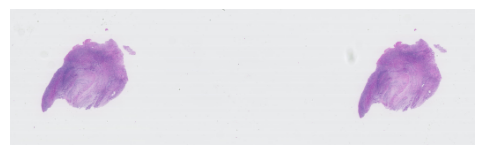

done setting tile size to 1000 , and overlap to 100
done tiling the slide
Number of sections in slide: 4
done saving tiles in section 0
done saving tiles in section 1
done saving tiles in section 2
done saving tiles in section 3
done with all sections


In [11]:
############## tiles from geojson Margin areas ###########

out_tile_dir = Path('/raid/aarlova/NIH/NIH/tiles20x/')

for i in range(len(slide_list)):
    slide_fname = Path(slide_dir + '/' + slide_list[i] + '.ndpi')
    print('~~~~~~~~~~~~~~~~~~~~~~')
    print(slide_fname)
    jsons_fname = Path('/media/14TB/aarlova_ovarian/margin_jsons_for_NIH/' + slide_list[i] + '.geojson')
    slide = openslide.OpenSlide(str(slide_fname))
    levels = int(slide.level_count)
    thumb_dim = slide.level_dimensions[levels - 2]  # highest level corresponds to smallest available dimension
    downsample_factor = int(slide.level_downsamples[levels - 2])  # corresponding downsample factor of the thumbnail to be produced

    wsi_thumb = slide.get_thumbnail(thumb_dim)
    plt.imshow(wsi_thumb)
    plt.savefig(save_info_dir+str(slide_fname.stem)+'_thumb.jpg')

    plt.axis('off')
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()
    
    # coords, labels = read_geojson(jsons_fname)
    coords = read_geojson_nolabel(jsons_fname)
    polygons = [Polygon(i[0]) for i in coords]
    
    #### for qupath_json:
    # coords = read_qupath_json(jsons_fname)
    # polygons = [Polygon(i) for i in coords]

    
    # generate a grid of tiles of specific size and overlap within bounds of the Ovary
    tile_size = 1000
    ol = 100
    print('done setting tile size to', tile_size, ', and overlap to', ol)

    slide_grid = get_grid(polygons, tile_size, ol, plot=False)
    print('done tiling the slide')
    
    # visualize the resulting polygons
    fig, axs = plt.subplots()
    axs.set_aspect('equal', 'datalim')
    axs.invert_yaxis()

    for geom in polygons:
        xs, ys = geom.exterior.xy
        axs.plot(xs, ys, color='b', linestyle='-', linewidth=0.3)

    plt.savefig(save_info_dir+str(slide_fname.stem)+'_thumb_mask.jpg')
    # plt.show()

    plt.cla()
    plt.clf()
    plt.close()
    

    # tile the slide with my script, get slide_grid
    print('Number of sections in slide:', len(slide_grid))
    for section in range(len(slide_grid)):
        # print('Number of tiles in current section:', len(slide_grid[section]))
        for tile in range(len(slide_grid[section])):
            current_tile = slide_grid[section][tile]
            current_tile_top_left_coord = [int(current_tile.bounds[0]), int(current_tile.bounds[1])]  # this should be minx, miny if polygons were created with ccw=False
            tile_dir = Path(out_tile_dir/slide_fname.stem)
            tile_dir.mkdir(parents=True, exist_ok=True)

            tile_name = str(out_tile_dir/slide_fname.stem) + '/' + str(slide_fname.stem) + ' [x=' + str(current_tile_top_left_coord[0]) + ',y=' + str(current_tile_top_left_coord[1]) + ',w='+str(tile_size) + ',h=' + str(tile_size) + '].jpg'
            tile_img = slide.read_region((current_tile_top_left_coord[0], current_tile_top_left_coord[1]),0,(tile_size,tile_size)).convert('RGB')
            resized_tile = tile_img.resize((500,500)) # uncomment this line and next for 20x
            resized_tile.save(tile_name)
            
            resized_tile.close()
            tile_img.close()

        print('done saving tiles in section', section)
        
    

    print('done with all sections')
    slide.close()
